In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re, os, IPython, time
from pyteomics import mass
from Download_UnimodDB import Download_Unimod_Dict
unimod = Download_Unimod_Dict()
from utility_functions import *
DATE

'20250626'

In [2]:
my_palette = [project_palette['trembl'], project_palette['openprot']]

In [3]:
working_folder = "C:/Users/Enrico/OneDrive - UGent/run-ionbot"
PXDs = ["PXD002057.v0.11.4","PXD005833.v0.11.4","PXD014258.v0.11.4"]
filtering = 'custom'

------

In [4]:
combo = []
for dataset_name in PXDs:
    combo.append(pd.read_csv(os.path.join(working_folder, dataset_name, f'openprot-x-trembl-filt-{filtering}.csv')))
combo = pd.concat(combo, ignore_index=True)

In [5]:
print(combo.shape)
combo = combo[combo.matched_peptide_open==combo.matched_peptide_open].copy(deep=True)
print(combo.shape)
combo['by-count-norm_trembl'] = combo['by-count_trembl'] / combo.matched_peptide_trembl.apply(len)
combo['by-count-norm_open']   = combo['by-count_open'] / combo.matched_peptide_open.apply(len)
combo['y-count-norm_trembl']  = combo['y-count_trembl'] / combo.matched_peptide_trembl.apply(len)
combo['y-count-norm_open']    = combo['y-count_open'] / combo.matched_peptide_open.apply(len)
combo['b-count-norm_trembl']  = combo['b-count_trembl'] / combo.matched_peptide_trembl.apply(len)
combo['b-count-norm_open']    = combo['b-count_open'] / combo.matched_peptide_open.apply(len)
print(combo.shape)

(317994, 64)
(317994, 64)
(317994, 70)


In [6]:
## keep only one modified peptide when 2 are possible
combo.modifications_trembl = combo.modifications_trembl.fillna('').apply(lambda x: x.split('_or_')[0])
combo.modifications_open   = combo.modifications_open.fillna('').apply(lambda x: x.split('_or_')[0])

#### Comparing specific subgroups

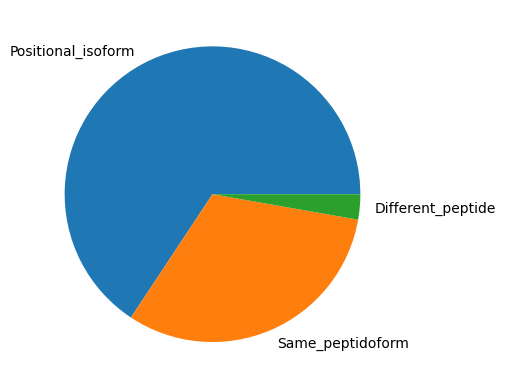

In [7]:
def samepep_and_samemod(row):
    if row.Same_peptide and row.Same_mods_noRT:
        return 'Same_peptidoform'
    elif row.Same_peptide and not row.Same_mods_noRT:
        return 'Positional_isoform'
    elif not row.Same_peptide and not row.Same_mods_noRT:
        return 'Different_peptide'
        
combo['samepep_samemod'] = combo.apply(samepep_and_samemod, axis=1)

y = combo['samepep_samemod'].value_counts()
plt.pie(y, labels=y.index)
plt.show() 

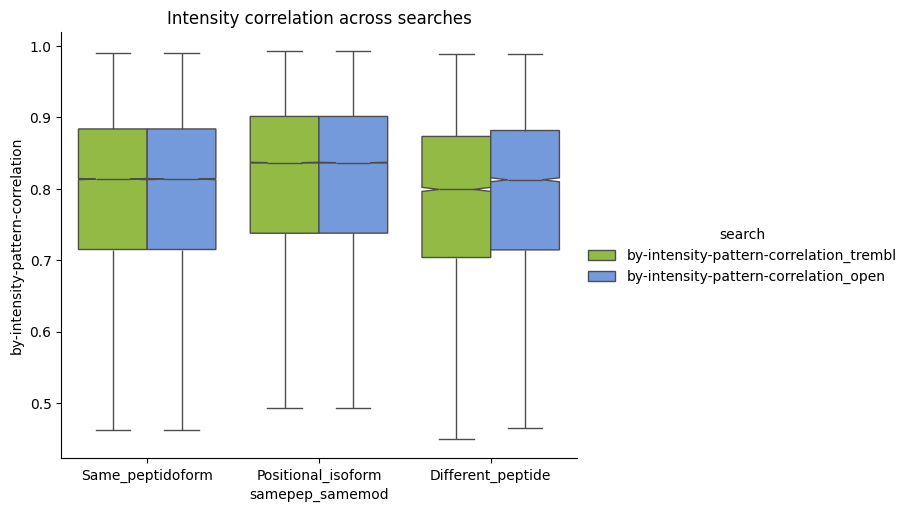

In [8]:
VAR = 'samepep_samemod'
ORDER = ['Same_peptidoform','Positional_isoform','Different_peptide']

tmp = combo.melt(id_vars=['spectrum_title','scan','spectrum_file',VAR], 
                           value_vars=['by-intensity-pattern-correlation_trembl',
                                       'by-intensity-pattern-correlation_open'], 
                           var_name='search', value_name='value')
sns.catplot(data=tmp, kind='box', x=VAR, y='value', hue='search', aspect=1.25, showfliers=False, notch=True, 
            palette=my_palette, order=ORDER)
plt.title('Intensity correlation across searches')
plt.ylabel('by-intensity-pattern-correlation')
# sns.catplot(data=tmp, kind='point', x=VAR, y='value', hue='search', linestyle='none', dodge=True, aspect=1.25,
#             palette=my_palette, order=ORDER)
# plt.title('Intensity correlation across searches')
# plt.ylabel('by-intensity-pattern-correlation')
plt.show()

In [9]:
VAR, VAL = 'samepep_samemod','by-intensity-pattern-correlation'
for i,df in combo.groupby(VAR).__iter__():
    _,pval = stats.mannwhitneyu(df[f'{VAL}_trembl'],
                                df[f'{VAL}_open'])
    print(f'{i} p={pval:.1e} {pval<.05}')
print('\n')
for i,df in combo.groupby(VAR).__iter__():
    _,pval = stats.wilcoxon(df[f'{VAL}_trembl'],
                                df[f'{VAL}_open'])
    print(f'{i} p={pval:.1e} {pval<.05}')
print('\n')
for i,df in combo.groupby(VAR).__iter__():
    print(f'{i}', cohenD(df[f'{VAL}_trembl'],df[f'{VAL}_open']))

Different_peptide p=2.5e-08 True
Positional_isoform p=9.9e-01 False
Same_peptidoform p=9.7e-01 False


Different_peptide p=7.7e-77 True
Positional_isoform p=0.0e+00 True
Same_peptidoform p=2.0e-309 True


Different_peptide 0.081
Positional_isoform 0.0
Same_peptidoform 0.0


-----

In [10]:
combo['target_decoy'] = combo.apply(lambda row: f'{row.database_trembl}->{row.database_open}', axis=1)
combo.target_decoy.value_counts()
# counts too low!

target_decoy
T->T    316075
D->D      1201
T->D       424
D->T       294
Name: count, dtype: int64

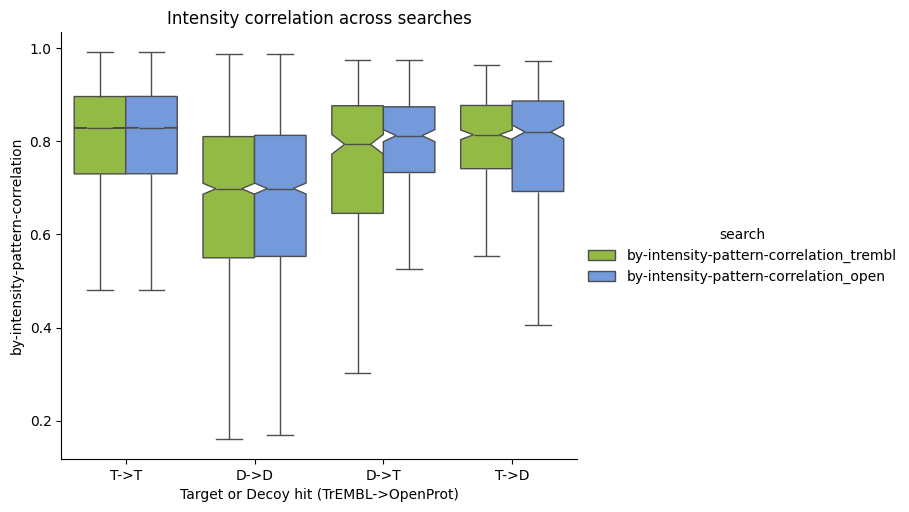

In [11]:
tmp = combo.melt(id_vars=['spectrum_title','scan','spectrum_file','target_decoy'], 
                           value_vars=['by-intensity-pattern-correlation_trembl',
                                       'by-intensity-pattern-correlation_open'], 
                           var_name='search', value_name='value')

sns.catplot(data=tmp, kind='box',   x='target_decoy', y='value', hue='search', 
            aspect=1.25, showfliers=False, notch=True, palette=my_palette, order=['T->T','D->D','D->T','T->D'])
plt.title('Intensity correlation across searches')
plt.xlabel('Target or Decoy hit (TrEMBL->OpenProt)')
plt.ylabel('by-intensity-pattern-correlation')

# sns.catplot(data=tmp, kind='point', x='target_decoy', y='value', hue='search', 
#             linestyle='none', aspect=1.25, dodge=True, palette=my_palette, order=['T->T','D->D','D->T','T->D'])
# plt.title('Intensity correlation across searches')
# plt.xlabel('Canonical protein hit (trEMBL->OpenProt)')
# plt.ylabel('by-intensity-pattern-correlation')
plt.savefig(os.path.join('publication-data', f'Fig3-final-2-{filtering}.svg'), dpi=300, bbox_inches='tight')

In [12]:
VAR, VAL = 'target_decoy','by-intensity-pattern-correlation'
for i,df in combo.groupby(VAR).__iter__():
    _,pval = stats.mannwhitneyu(df[f'{VAL}_trembl'],
                                df[f'{VAL}_open'])
    print(f'{i} p={pval:.1e} {pval<.05}')
print('\n')
for i,df in combo.groupby(VAR).__iter__():
    _,pval = stats.wilcoxon(df[f'{VAL}_trembl'],
                                df[f'{VAL}_open'])
    print(f'{i} p={pval:.1e} {pval<.05}')
print('\n')
for i,df in combo.groupby(VAR).__iter__():
    print(f'{i}', cohenD(df[f'{VAL}_trembl'],df[f'{VAL}_open']))

D->D p=7.1e-01 False
D->T p=8.8e-02 False
T->D p=4.5e-01 False
T->T p=3.9e-01 False


D->D p=2.8e-04 True
D->T p=2.1e-02 True
T->D p=7.5e-02 False
T->T p=0.0e+00 True


D->D 0.014
D->T 0.246
T->D 0.188
T->T 0.002


----

In [13]:
combo['canon_before_after'] = combo.apply(lambda row: f'{row.isCanonical_trembl}->{row.isCanonical_open}', axis=1)
combo.canon_before_after.value_counts(sort=False)

canon_before_after
Canonical->Canonical       315264
Canonical->NonCanonical      2730
Name: count, dtype: int64

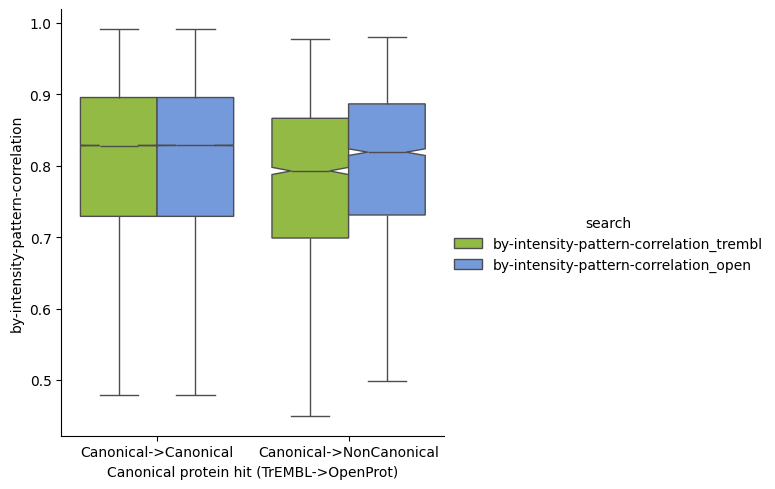

In [14]:
VAR, VAL =  'canon_before_after', 'by-intensity-pattern-correlation',
tmp = combo.melt(id_vars=['spectrum_title','scan','spectrum_file',VAR], 
                       value_vars=[f'{VAL}_trembl',f'{VAL}_open'], 
                       var_name='search', value_name='value')

sns.catplot(data=tmp, kind='box', x=VAR, y='value', hue='search', showfliers=False,
            notch=True, palette=my_palette,
           )
plt.xlabel('Canonical protein hit (TrEMBL->OpenProt)')
# plt.xticks(rotation=90)
plt.ylabel(VAL)

# sns.catplot(data=tmp, kind='point', x=VAR, y='value', hue='search', linestyle='none', dodge=True,
#             palette=my_palette, 
#            )
# plt.xlabel('Canonical protein hit (UniProt->OpenProt)')
# plt.xticks(rotation=90)
# plt.ylabel(VAL)

# plt.show()
plt.savefig(os.path.join('publication-data', f'Fig3-final-1-{filtering}.svg'), dpi=300, bbox_inches='tight')

In [15]:
VAR, VAL =  'canon_before_after', 'by-intensity-pattern-correlation',
for i,df in combo.groupby(VAR).__iter__():
    _,pval = stats.mannwhitneyu(df[f'{VAL}_trembl'],
                                df[f'{VAL}_open'])
    print(f'{i} p={pval:.1e} {pval<.05}')
print('\n')
for i,df in combo.groupby(VAR).__iter__():
    _,pval = stats.wilcoxon(df[f'{VAL}_trembl'],
                                df[f'{VAL}_open'])
    print(f'{i} p={pval:.1e} {pval<.05}')
print('\n')
for i,df in combo.groupby(VAR).__iter__():
    print(f'{i}', cohenD(df[f'{VAL}_trembl'],df[f'{VAL}_open']))

Canonical->Canonical p=8.5e-01 False
Canonical->NonCanonical p=1.2e-15 True


Canonical->Canonical p=0.0e+00 True
Canonical->NonCanonical p=3.2e-131 True


Canonical->Canonical 0.001
Canonical->NonCanonical 0.223


In [16]:
autosave(extra_labels='-'+filtering)
filtering

True


'custom'

#### Overall comparison -- unused

-----